# **Лабораторна робота №2 “EDA and Supervised Learning”**
Виконав студент групи КН-31, Бенза Роман Анатолійович

**Мета:** Навчитись EDA та моделюванню для задач з учителем.

**Завдання:**
1. Завантажити дані з Kaggle (опис — у HomeCredit_columns_description.csv).

2. Провести EDA на `application_{train|test}.csv`: описати дані, розподіли, пропуски, баланс класів, обробка пропусків, відмінності train/test.

3. Побудувати класифікатор (будь-який метод), оцінити якість через train-val-split (метрика — ROC_AUC).

4. Класифікувати `application_test.csv`, зберегти результат у submission-файл (як у sample_submission.csv).

5. Завантажити submission на платформу, отримати оцінку, зробити скріншот та додати до фінального ноутбука.


## **A. Загальний огляд набору даних.**

Для початку підвантажимо дані для завдання зі змагання на Kaggle за допомогою бібліотеки pandas:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc

pd.set_option('display.max_columns', 122)
pd.set_option('display.max_rows', 122)

Тренувальні дані:

In [3]:
df_train = pd.read_csv('data/application_train.csv')
print('Розмірність тренувального набору:', df_train.shape)
df_train.head(5)

Розмірність тренувального набору: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Тестові дані:

In [4]:
df_test = pd.read_csv('data/application_test.csv')
print('Розмірність тестувального набору:', df_test.shape)
df_test.head(5)

Розмірність тестувального набору: (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

Бачимо, що набір має 121 ознаку (122-га ознака - ознака класу). Тестовий набір має 48744 екземплярів, тренувальний - 307511. На наступному етапі EDA важливо отримати картину про дублікати. Перевіримо набір на повтори, але перед цим важливо виключити колонку з ID запиту, оскільки воно різне для кожного екземпляру даних:

In [5]:
cols = df_train.columns.tolist()
temp = [col for col in cols if col != "SK_ID_CURR"]
repeatedRowsAmount = df_train.duplicated(subset=temp).sum()
print(f'Датасет налічує {repeatedRowsAmount} дублікатів')

Датасет налічує 0 дублікатів


Отже, набір даних не налічує дублікатів, що звільнює нас від проблеми їх обробки. Наступним логічним кроком є перевірка на пропущені значення в колонках:

In [6]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum() / df_train.isnull().count() * 100).sort_values(ascending=False)

missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Total'] > 0]

print(f"У датафреймі {df_train.shape[1]} колонок.")
print(f"З них {missing_data.shape[0]} мають пропущені значення.")

missing_data.style.background_gradient(cmap='Reds', subset=['Percent']).format({'Percent': "{:.3f}%"})

У датафреймі 122 колонок.
З них 67 мають пропущені значення.


,Total,Percent
COMMONAREA_AVG,214865,69.872%
COMMONAREA_MODE,214865,69.872%
COMMONAREA_MEDI,214865,69.872%
NONLIVINGAPARTMENTS_MEDI,213514,69.433%
NONLIVINGAPARTMENTS_MODE,213514,69.433%
NONLIVINGAPARTMENTS_AVG,213514,69.433%
FONDKAPREMONT_MODE,210295,68.386%
LIVINGAPARTMENTS_AVG,210199,68.355%
LIVINGAPARTMENTS_MEDI,210199,68.355%
LIVINGAPARTMENTS_MODE,210199,68.355%


Як наглядно видно із таблиці вище, приблизно 50 колонок мають проблеми із пропущеними даними, які точно треба буде обробити. Якісь колонки ми видалимо, щоб ті не спотворили роботу моделі, а якісь заповнимо деякими значеннями.

## **B. Кореляція ознак**

Наступним важливим кроком EDA є оцінка кореляції ознак. Цей аналіз дозволяє виявити ступінь лінійної залежності між змінними, щоб зрозуміти, які фактори мають найбільший вплив на цільову змінну та потенційно є найбільш значущими для прогнозування. Крім того, дослідження кореляційної матриці необхідне для виявлення мультиколінеарності — дублювання інформації в різних ознаках, що дозволить надалі відфільтрувати надлишковий шум та спростити модель без втрати якості.

В стандартному випадку зручніше всього робити теплову карту кореляції ознак, але в нас їх аж 122, що буде виглядати як незрозуміла каша, тому треба підійти трошки інакше до цього етапу, а не тупо писати хітмапу по всіх ознаках.

Найцікавіше в цьому етапі - продивитися, які ознаки найбільше корелюють із таргетом, тобто таким чином ми виявимо найцінніші змінні датасету:

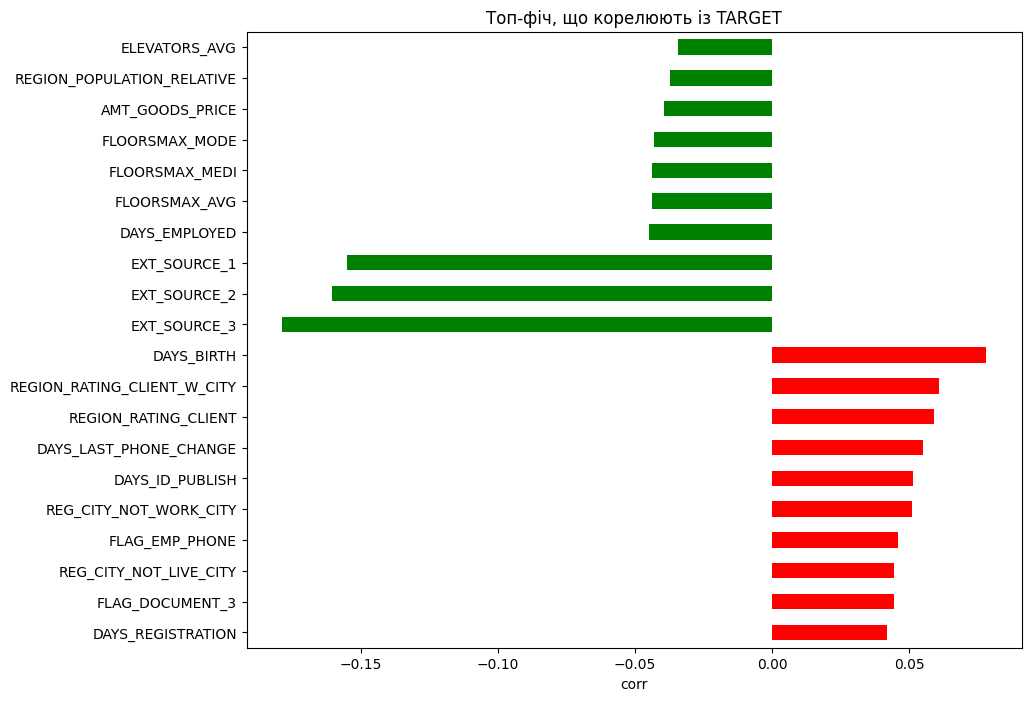

In [7]:
correlations = df_train.select_dtypes(include=['float64', 'int64']).corr()['TARGET'].sort_values()

bestPos = correlations.head(10)
bestNeg = correlations.tail(11).drop('TARGET')

plt.figure(figsize=(10, 8))
colors = ['red']*10 + ['green']*10
pd.concat([bestNeg, bestPos]).plot(kind='barh', color=colors)
plt.title('Топ-фіч, що корелюють із TARGET')
plt.xlabel('corr')
plt.show()

Аналіз показує, що найбільший обернений зв’язок із цільовою змінною мають зовнішні скорингові оцінки (EXT_SOURCE_X), що робить їх найважливішими індикаторами надійності позичальника. Серед ознак із прямою кореляцією найсильніший вплив має вік клієнта (DAYS_BIRTH), що вказує на залежність ризику від вікової групи. В цілому ж, кореляційні коефіцієнти є відносно невисокими, що підтверджує складність залежності й свідчить про те, що для точного прогнозу знадобиться комбінація багатьох слабких факторів, а не покладання на один сильний.

Далі подивимося, які ознаки найбільше корелюють між собою, тобто перевіримо фічі на наявність мультиколінеарності. Видалення таких ознак особливо не впливає на якість роботи моделі, але може пришвидшити її роботу та зручність роботи з набором даних.

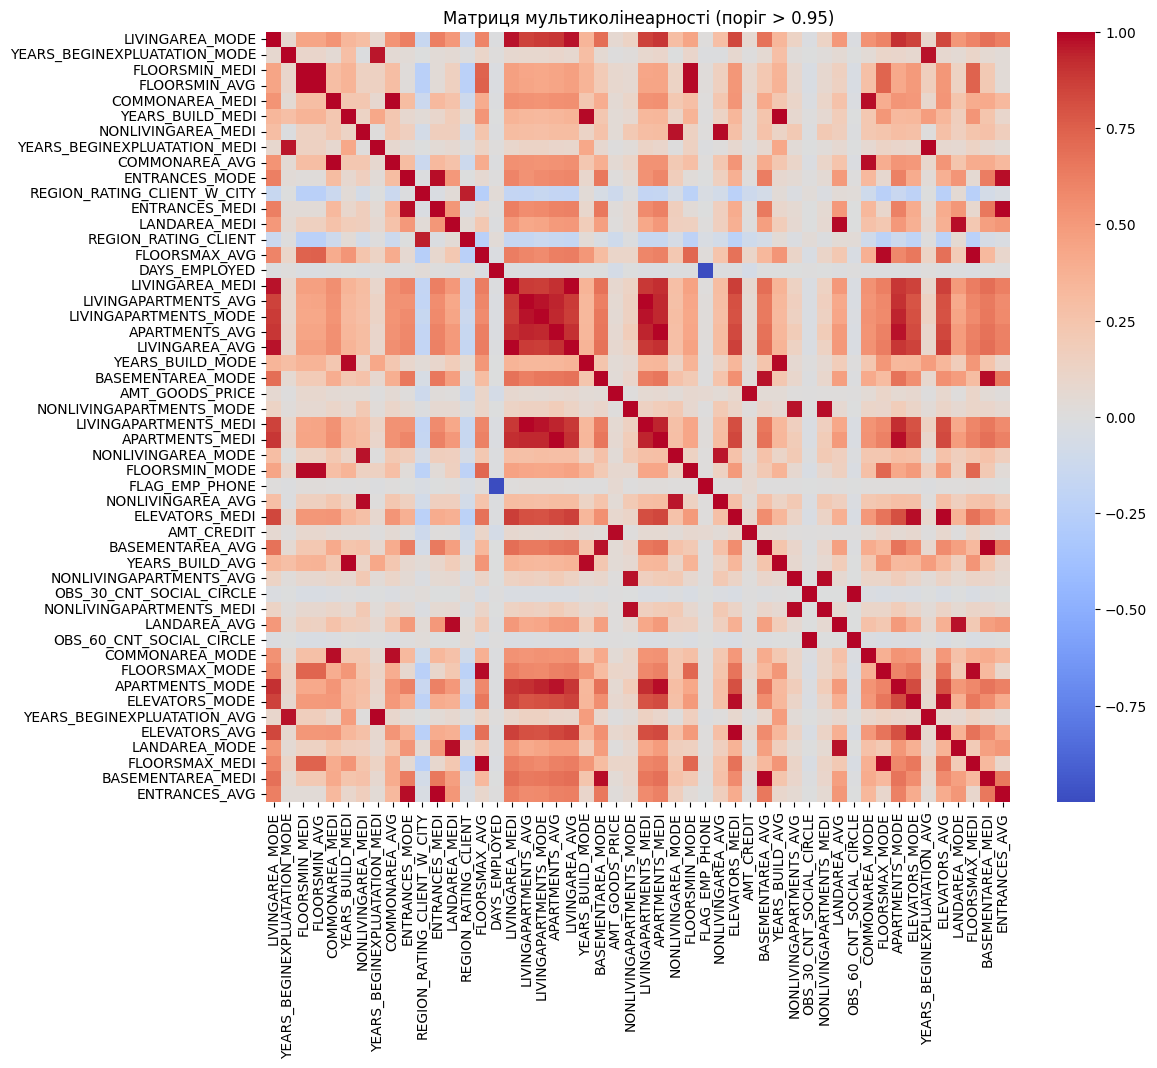

Знайдено 32 колонок-кандидатів на видалення (кореляція > 0.95).


In [8]:
threshold = 0.95

correlations = df_train.select_dtypes(include=['number']).corr().abs()

upper = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(bool))

toDrop = [column for column in upper.columns if any(upper[column] > threshold)]

collinearCols = set(toDrop)
for col in toDrop:
    correlated_with = upper.index[upper[col] > threshold].tolist()
    collinearCols.update(correlated_with)

df_collinear = df_train[list(collinearCols)]
plt.figure(figsize=(12, 10))
sns.heatmap(df_collinear.corr(), cmap='coolwarm', annot=False, center=0)
plt.title(f'Матриця мультиколінеарності (поріг > {threshold})')
plt.show()

print(f"Знайдено {len(toDrop)} колонок-кандидатів на видалення (кореляція > {threshold}).")

Аналіз виявив групи ознак із коефіцієнтом кореляції > 0.95 (зокрема, метрики житла AVG/MEDI/MODE). Це вказує на сильну мультиколінеарність. Для покращення якості моделі та уникнення перенавчання треба залишити лише одну репрезентативну ознаку з кожної групи.

## **C. Окремий огляд ознак**

Оскільки набір даних налічує 122 ознаки, то для прикладу ми подивимося на властивості тільки найцікавіших з них. Для початку подивимося на загальний розподіл ознаки TARGET по наборах даних:

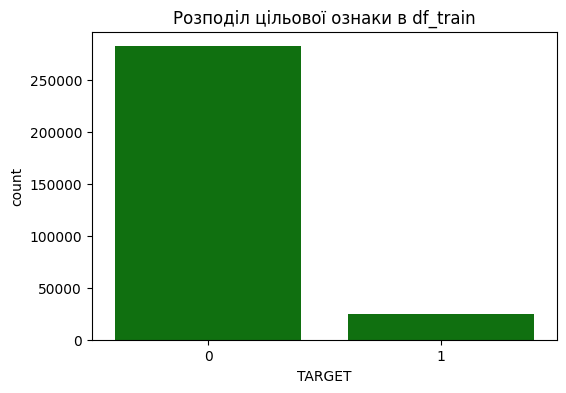

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_train, x='TARGET', color='green')
plt.title('Розподіл цільової ознаки в df_train')
plt.show()

Аналіз розподілу цільової змінної TARGET виявив суттєвий дисбаланс класів: переважна більшість прикладів у навчальній вибірці (понад 280 000) належить до класу 0 (позичальники, що повернули кредит), тоді як клас 1 (дефолт) представлений значно меншою кількістю записів (менше 25 000). Такий розподіл є типовим для задач виявлення шахрайства або кредитного скорингу, проте він створює ризик, що модель буде схильна завжди передбачати клас 0 для досягнення високої точності. Це вимагає використання стійких до дисбалансу метрик (ROC-AUC або F1).

Визначимо загальні функції, що будуть будувати статистику по ознаках:

In [10]:
def getCatStats(feature, target_col='TARGET', rotate_labels=45):
  df_tr = df_train.copy()
  df_tr[feature] = df_tr[feature].fillna('XNA / NaN').astype(str)

  if df_test is not None:
      df_ts = df_test.copy()
      df_ts[feature] = df_ts[feature].fillna('XNA / NaN').astype(str)

  print(f"=== Аналіз категорії: {feature} ===")
  print(f"Унікальних значень: {df_tr[feature].nunique()}")
  print("-" * 30)

  fig, axes = plt.subplots(2, 1, figsize=(12, 12))

  train_counts = df_tr[feature].value_counts(normalize=True).reset_index()
  train_counts.columns = [feature, 'Frequency']
  train_counts['Dataset'] = 'Train'

  data_to_plot = train_counts

  if df_test is not None:
      test_counts = df_ts[feature].value_counts(normalize=True).reset_index()
      test_counts.columns = [feature, 'Frequency']
      test_counts['Dataset'] = 'Test'
      data_to_plot = pd.concat([train_counts, test_counts], axis=0)

  sns.barplot(x=feature, y='Frequency', hue='Dataset', data=data_to_plot, ax=axes[0], palette='muted')
  axes[0].set_title(f'Частка кожної категорії (Train vs Test)')
  axes[0].set_ylabel('Частка')
  axes[0].tick_params(axis='x', rotation=rotate_labels)


  group_risk = df_tr.groupby(feature)[target_col].mean().sort_values(ascending=False).reset_index()

  sns.barplot(x=feature, y=target_col, data=group_risk, ax=axes[1], palette='Reds_r', order=group_risk[feature])
  global_mean = df_tr[target_col].mean()
  axes[1].axhline(global_mean, color='k', linestyle='--', label=f'Global Mean: {global_mean:.2%}')

  axes[1].set_title(f'Ризиковість категорії (Ймовірність TARGET=1)')
  axes[1].set_ylabel('Відсоток дефолтів')
  axes[1].tick_params(axis='x', rotation=rotate_labels)
  axes[1].legend()

  plt.tight_layout()
  plt.show()

In [11]:
def getNumStats(feature, target_col='TARGET'):
  sns.set_style("whitegrid")

  fig, axes = plt.subplots(3, 1, figsize=(12, 12))

  sns.histplot(df_train[feature], bins=30, kde=True, ax=axes[0], color='#5D6D7E', edgecolor='black', alpha=0.6)
  axes[0].set_title(f'Загальний розподіл: {feature}', fontsize=12, fontweight='bold')
  axes[0].set_xlabel('')

  sns.kdeplot(
      data=df_train,
      x=feature,
      hue=target_col,
      fill=True,
      common_norm=False,
      palette={0: '#2E86C1', 1: '#E74C3C'},
      alpha=0.3,
      linewidth=2,
      ax=axes[1]
  )
  axes[1].set_title(f'Порівняння щільності розподілу (KDE) за {target_col}', fontsize=12, fontweight='bold')
  axes[1].set_xlabel('')

  sns.boxplot(
      data=df_train,
      x=feature,
      y=target_col,
      orient='h',
      palette={str(0): '#2E86C1', str(1): '#E74C3C'},
      ax=axes[2],
      showmeans=True,
      meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"}
  )
  axes[2].set_title(f'Boxplot', fontsize=12, fontweight='bold')
  axes[2].set_xlabel(feature)

  plt.tight_layout()
  plt.show()

### **1. OCCUPATION_TYPE**

=== Аналіз категорії: OCCUPATION_TYPE ===
Унікальних значень: 19
------------------------------


C:\Users\User\AppData\Local\Temp\ipykernel_27640\2068164515.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y=target_col, data=group_risk, ax=axes[1], palette='Reds_r', order=group_risk[feature])


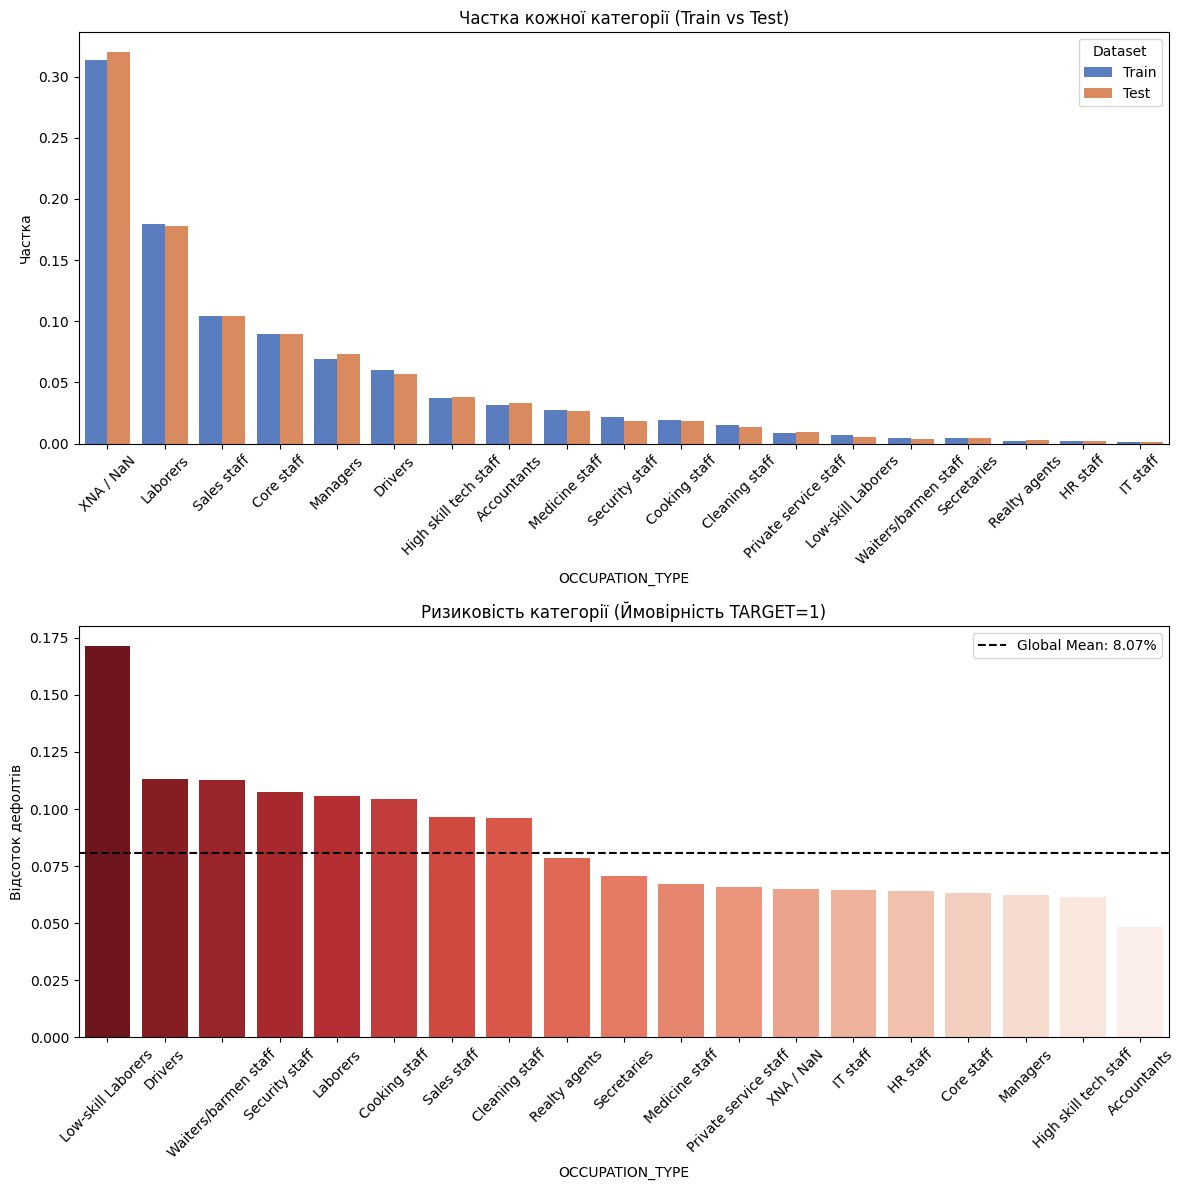

In [12]:
getCatStats('OCCUPATION_TYPE')

Ознака чітко розділяє клієнтів на групи з різним рівнем ризику:

* Спостерігається виражена залежність між кваліфікацією праці та ймовірністю дефолту. Робочі спеціальності (Low-skill Laborers, Drivers) мають рівень дефолту 11-17%, що значно перевищує середній по банку. Натомість офісні та висококваліфіковані професії (Accountants, High skill tech staff) є найбільш надійними (дефолт ~5%).

* Найпоширенішою категорією є XNA / NaN. Це означає, що третина клієнтів не вказує свою професію. Цікаво, що рівень ризику цієї групи невизначених є нижчим за середній - тобто відсутність запису не є сигналом про шахрайство.

* Розподіл професій у тренувальній та тестовій вибірках майже ідентичний.

### **2. CODE_GENDER**

=== Аналіз категорії: CODE_GENDER ===
Унікальних значень: 3
------------------------------


C:\Users\User\AppData\Local\Temp\ipykernel_27640\2068164515.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y=target_col, data=group_risk, ax=axes[1], palette='Reds_r', order=group_risk[feature])


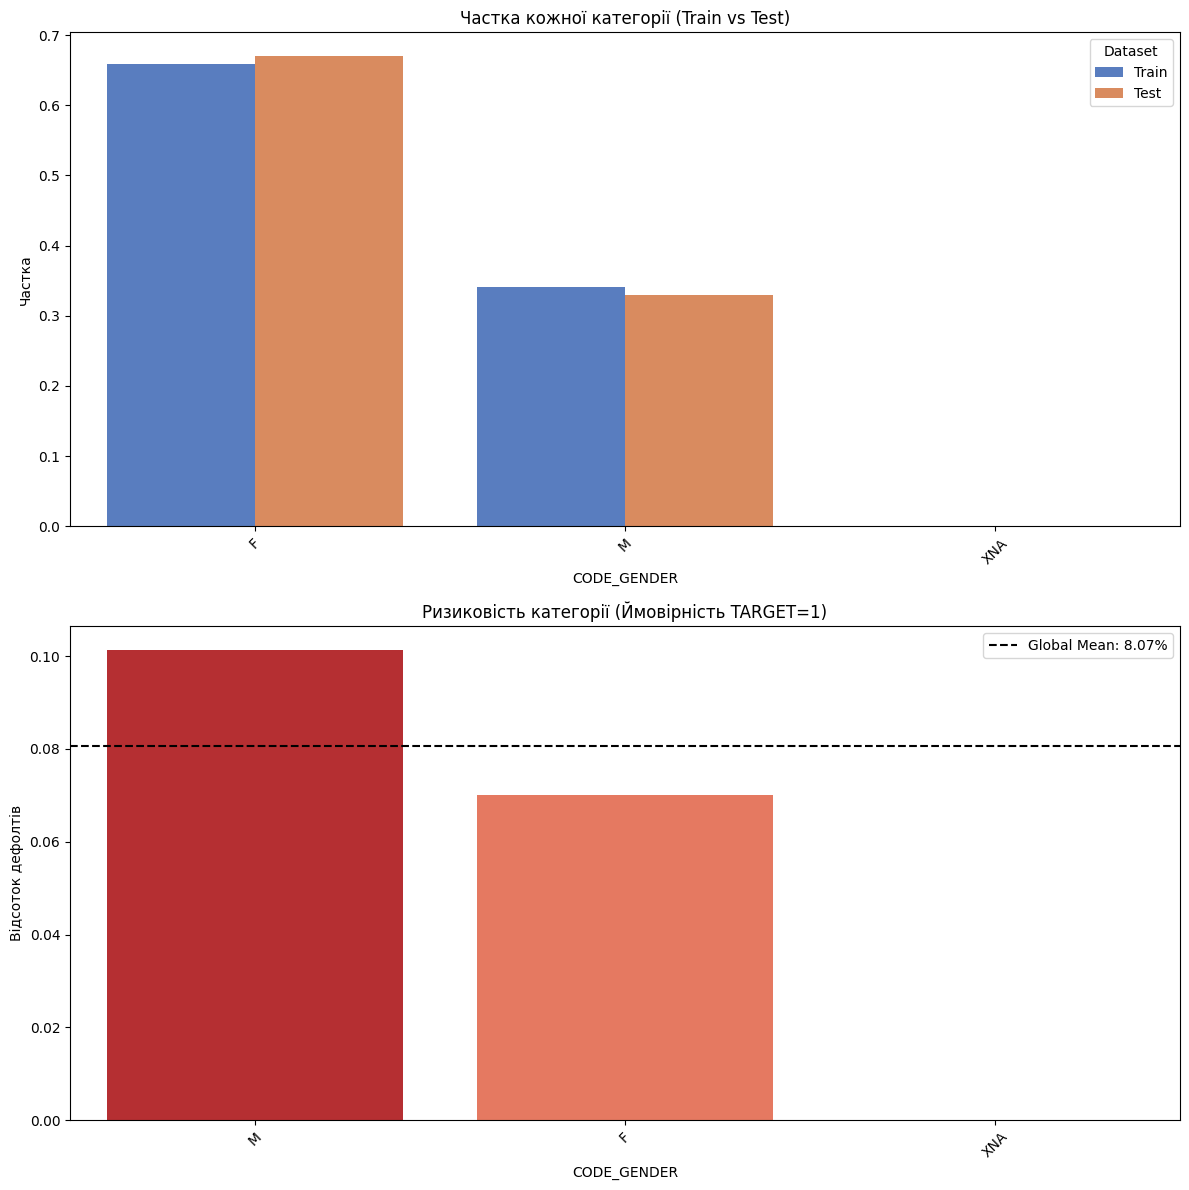

In [13]:
getCatStats('CODE_GENDER')

* Чоловіки статистично є менш надійними позичальниками. Рівень дефолту в цій групі перевищує 10%, що помітно вище за середній показник по банку. Натомість жінки демонструють кращу дисципліну з рівнем дефолту близько 7%.

* Жінки подають заявки на кредит значно частіше - вони становлять близько 66% всієї вибірки, тоді як чоловіки - лише 34%. Це свідчить про те, що портфель банку переважно сформований із жіночої аудиторії.

* На графіку видно категорію XNA. Це помилкові або пропущені дані. Оскільки стовпчика на графіку ризику майже не видно, таких записів критично мало.

### **3. NAME_EDUCATION_TYPE**

=== Аналіз категорії: NAME_EDUCATION_TYPE ===
Унікальних значень: 5
------------------------------


C:\Users\User\AppData\Local\Temp\ipykernel_27640\2068164515.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y=target_col, data=group_risk, ax=axes[1], palette='Reds_r', order=group_risk[feature])


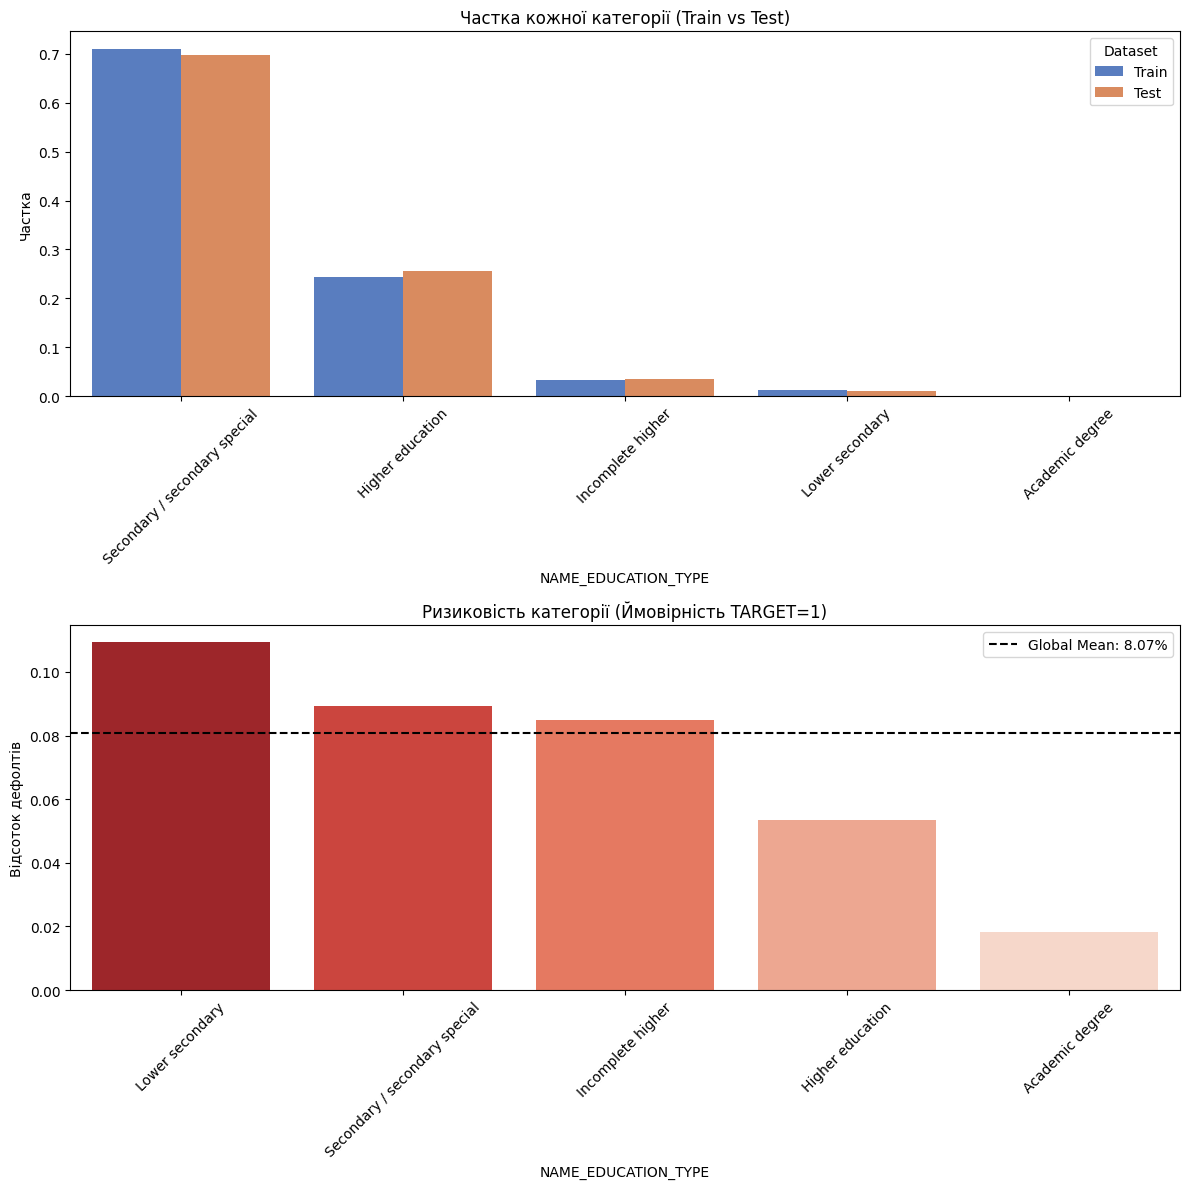

In [14]:
getCatStats('NAME_EDUCATION_TYPE')

Ознака має високу роздільну здатність та демонструє логічну монотонну залежність: чим вищий рівень освіти, тим нижчий ризик дефолту.

* Клієнти з категорією Lower secondary є найбільш ризиковими - рівень дефолту перевищує 10%. На іншому полюсі знаходяться власники наукових ступенів, де ризик мінімальний. Особи з вищою освітою також знаходяться у безпечній зоні.

* Основну масу позичальників (близько 70%) становлять люди із середньою спеціальною освітою. Саме ця група формує основний ризик.

### **4. FLAG_DOCUMENT_3**

=== Аналіз категорії: FLAG_DOCUMENT_3 ===
Унікальних значень: 2
------------------------------


C:\Users\User\AppData\Local\Temp\ipykernel_27640\2068164515.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y=target_col, data=group_risk, ax=axes[1], palette='Reds_r', order=group_risk[feature])


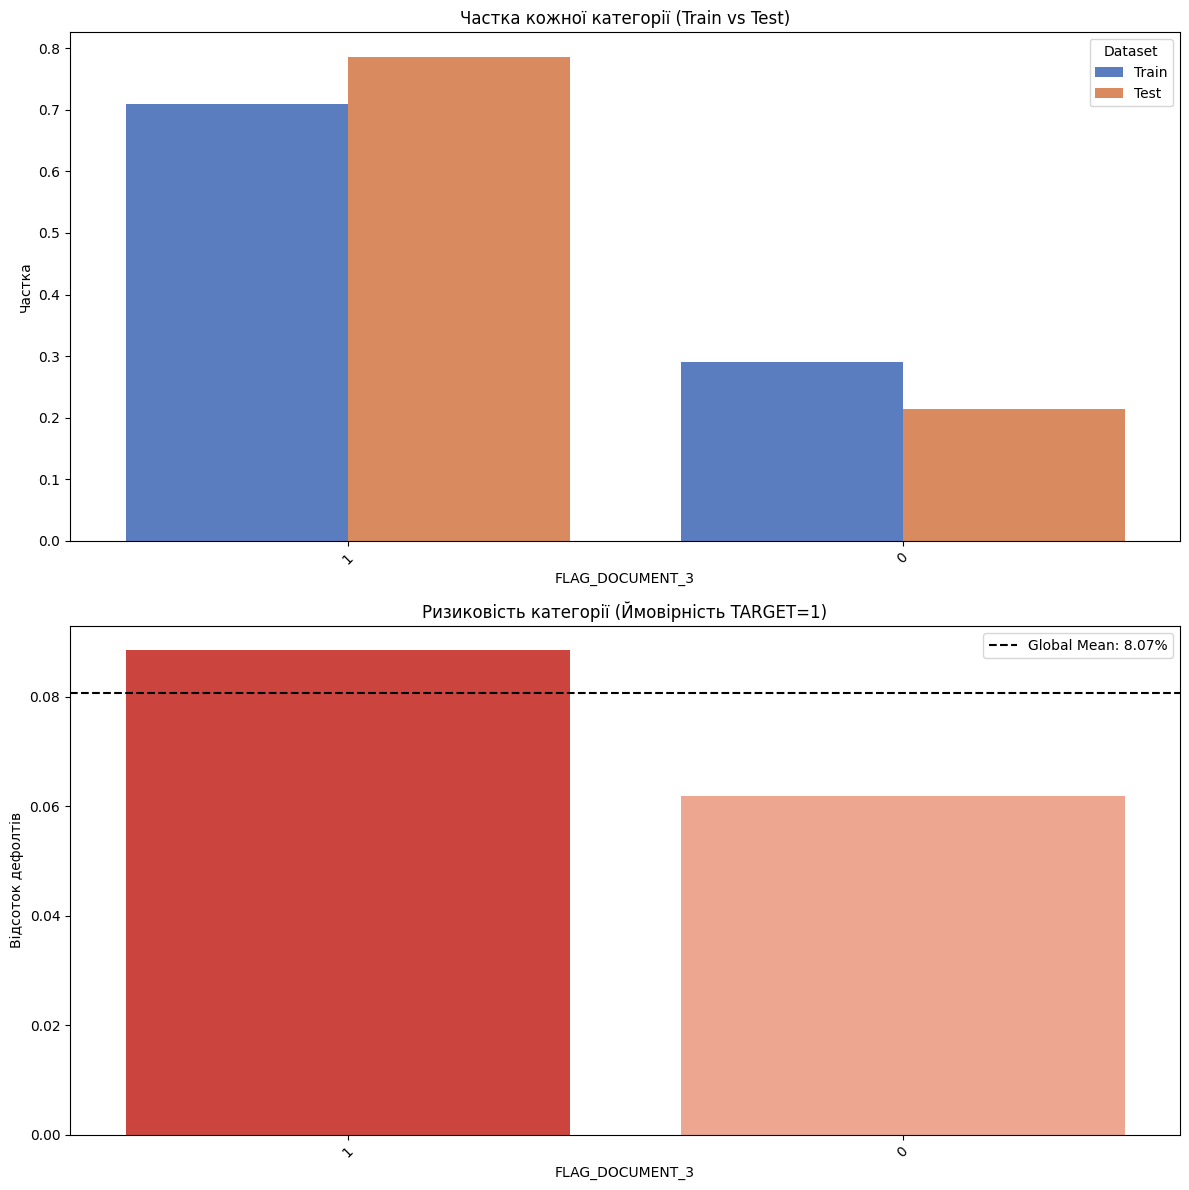

In [15]:
getCatStats('FLAG_DOCUMENT_3')

* Наявність документа пов'язана з вищим ризиком дефолту (~9%), що перевищує середній рівень по банку. Ті ж, хто цей документ не надав, виявляються надійнішими позичальниками.

* Помітна суттєва різниця між Train та Test. У тестовій вибірці частка клієнтів із документом зросла. Це явище може вказувати на зміну політики банку або вимог до пакету документів у часі.

* Абсолютна більшість клієнтів (понад 70%) мають цей прапорець, тому саме ця група формує основну статистику дефолтів.

### **5. NAME_CONTRACT_TYPE**

=== Аналіз категорії: NAME_CONTRACT_TYPE ===
Унікальних значень: 2
------------------------------


C:\Users\User\AppData\Local\Temp\ipykernel_27640\2068164515.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y=target_col, data=group_risk, ax=axes[1], palette='Reds_r', order=group_risk[feature])


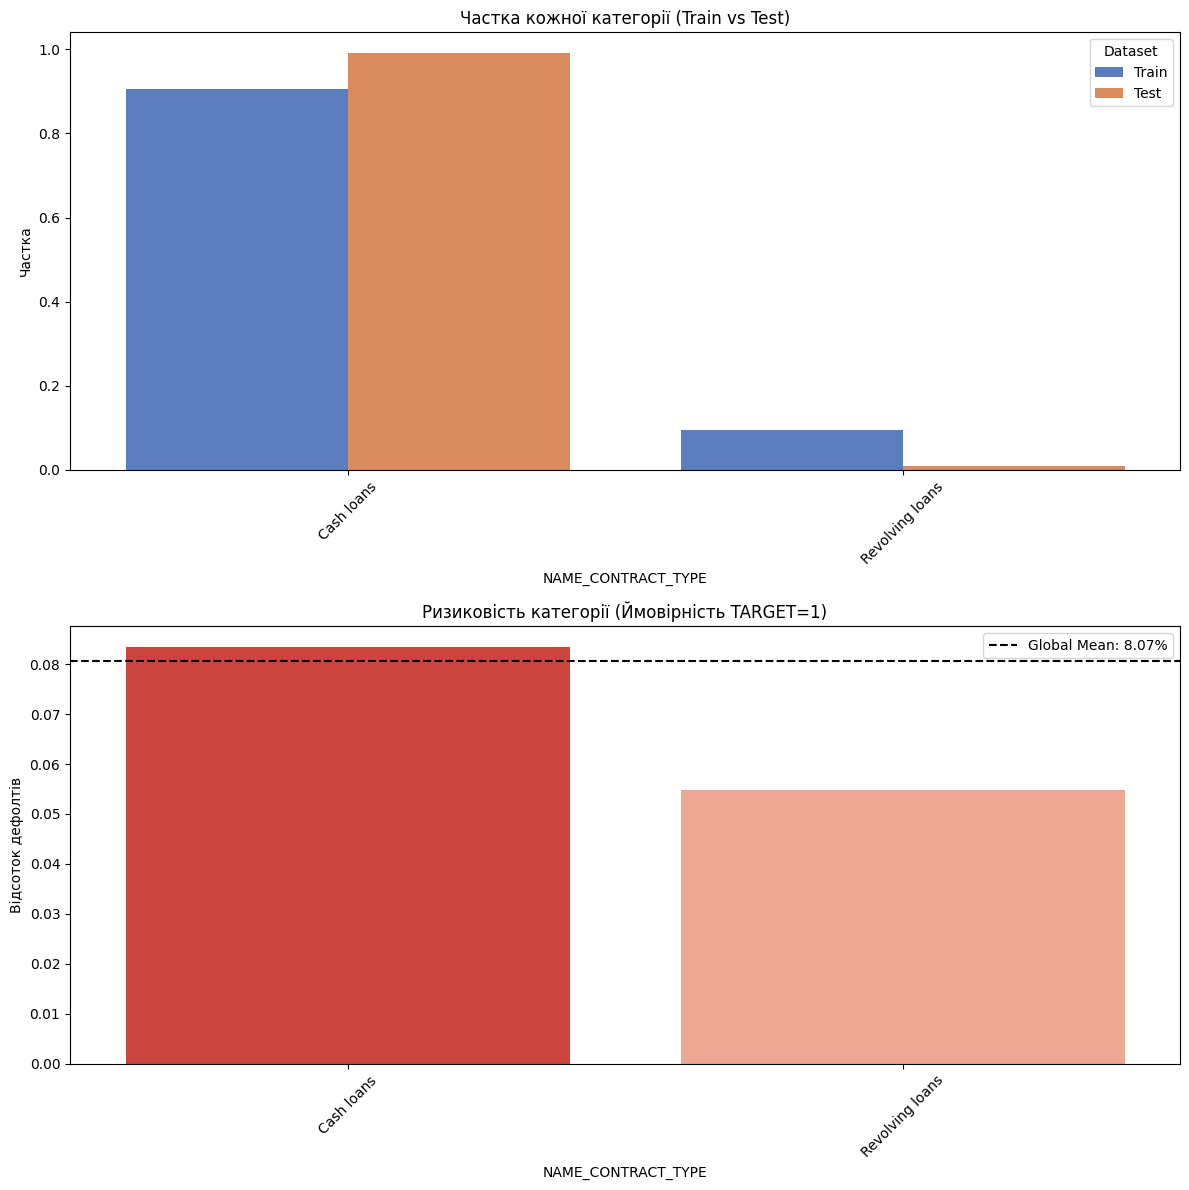

In [16]:
getCatStats('NAME_CONTRACT_TYPE')

* Готівкові кредити є більш ризиковими - рівень дефолту перевищує 8.3%, що вище за середній показник по банку. Натомість, револьверні кредити значно безпечніші - дефолт лише близько 5.5%.

* Абсолютна більшість портфеля — це готівкові кредити. Саме цей тип контрактів формує основну картину ризиків банку.

* Тестовий набір даних складається майже виключно з готівкових кредитів.

### **6. DAYS_BIRTH**


Оскільки вік даний нам у вигляді від'ємних днів, то для більшої інтерпретабельності переведемо цю ознаку в роки

C:\Users\User\AppData\Local\Temp\ipykernel_27640\2552968679.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


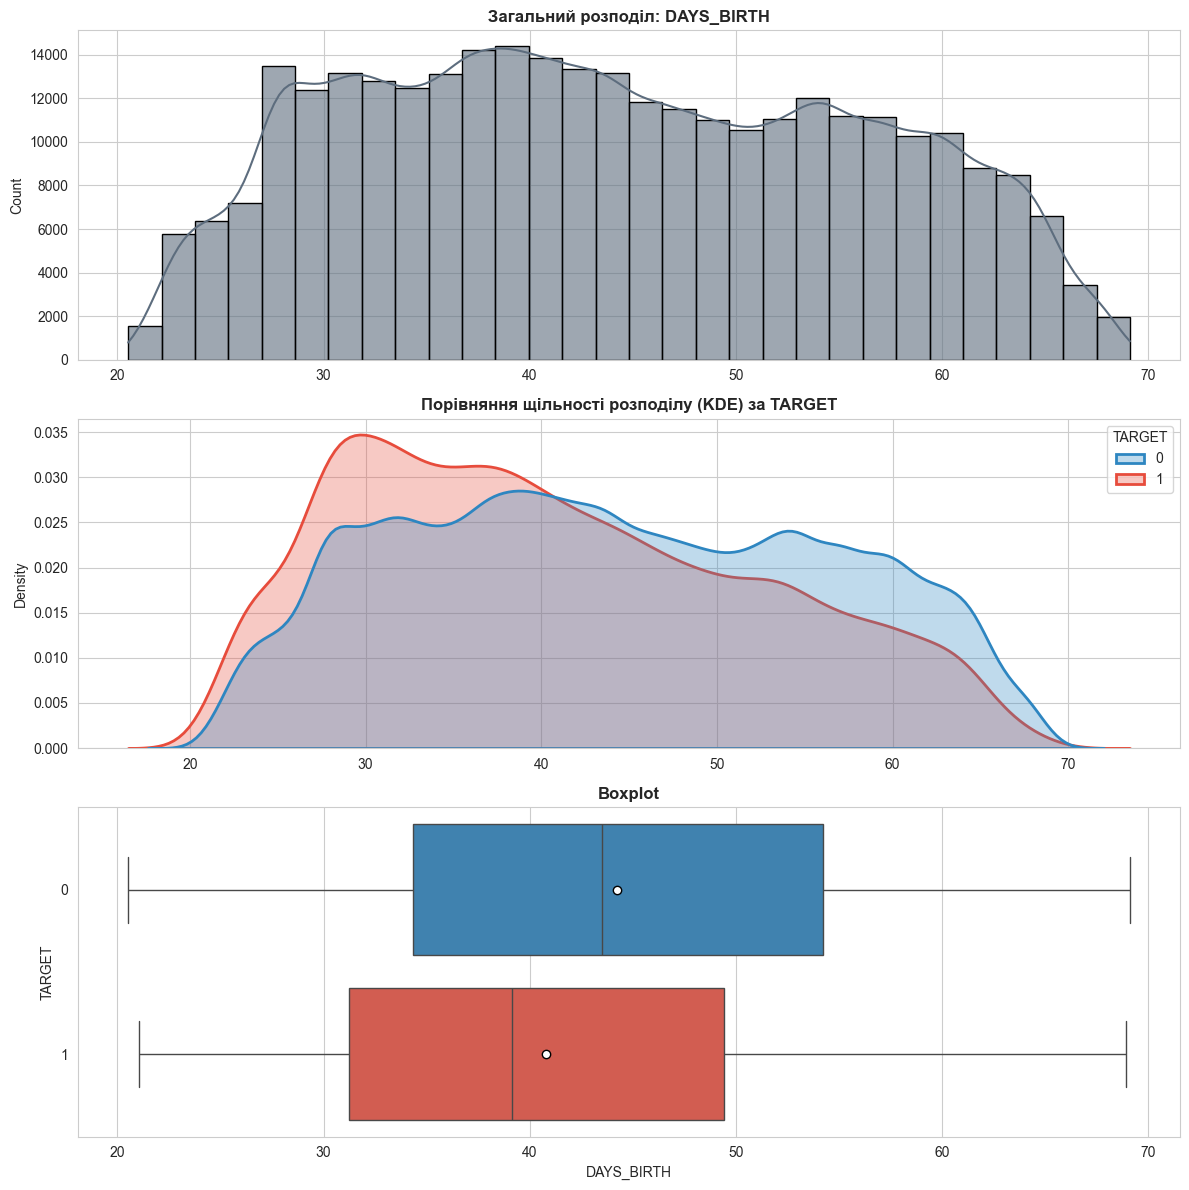

In [17]:
df_train['DAYS_BIRTH'] = -(df_train['DAYS_BIRTH'] / 365)
getNumStats('DAYS_BIRTH')

Ознака є одним із найсильніших предикторів у датасеті, демонструючи чітку обернену кореляцію між віком та ймовірністю дефолту.

* Спостерігається чіткий тренд: чим молодший клієнт, тим вищий ризик. На графіку KDE червона лінія має явний пік у діапазоні 20–30 років, тоді як синя лінія (надійні клієнти) є більш рівномірною і зміщена в бік старшого віку.

* Боксплот підтверджує візуальну різницю: медіанний вік боржників складає близько 40 років, що помітно менше за медіанний вік сумлінних платників, який становить приблизно 44 роки.

* Розподіл виглядає природним. Оутлаєрів на боксплоті не виявлено, що свідчить про те, що дані вже були попередньо очищені або спочатку коректні.

### **7. EXT_SOURCE**

C:\Users\User\AppData\Local\Temp\ipykernel_27640\2552968679.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


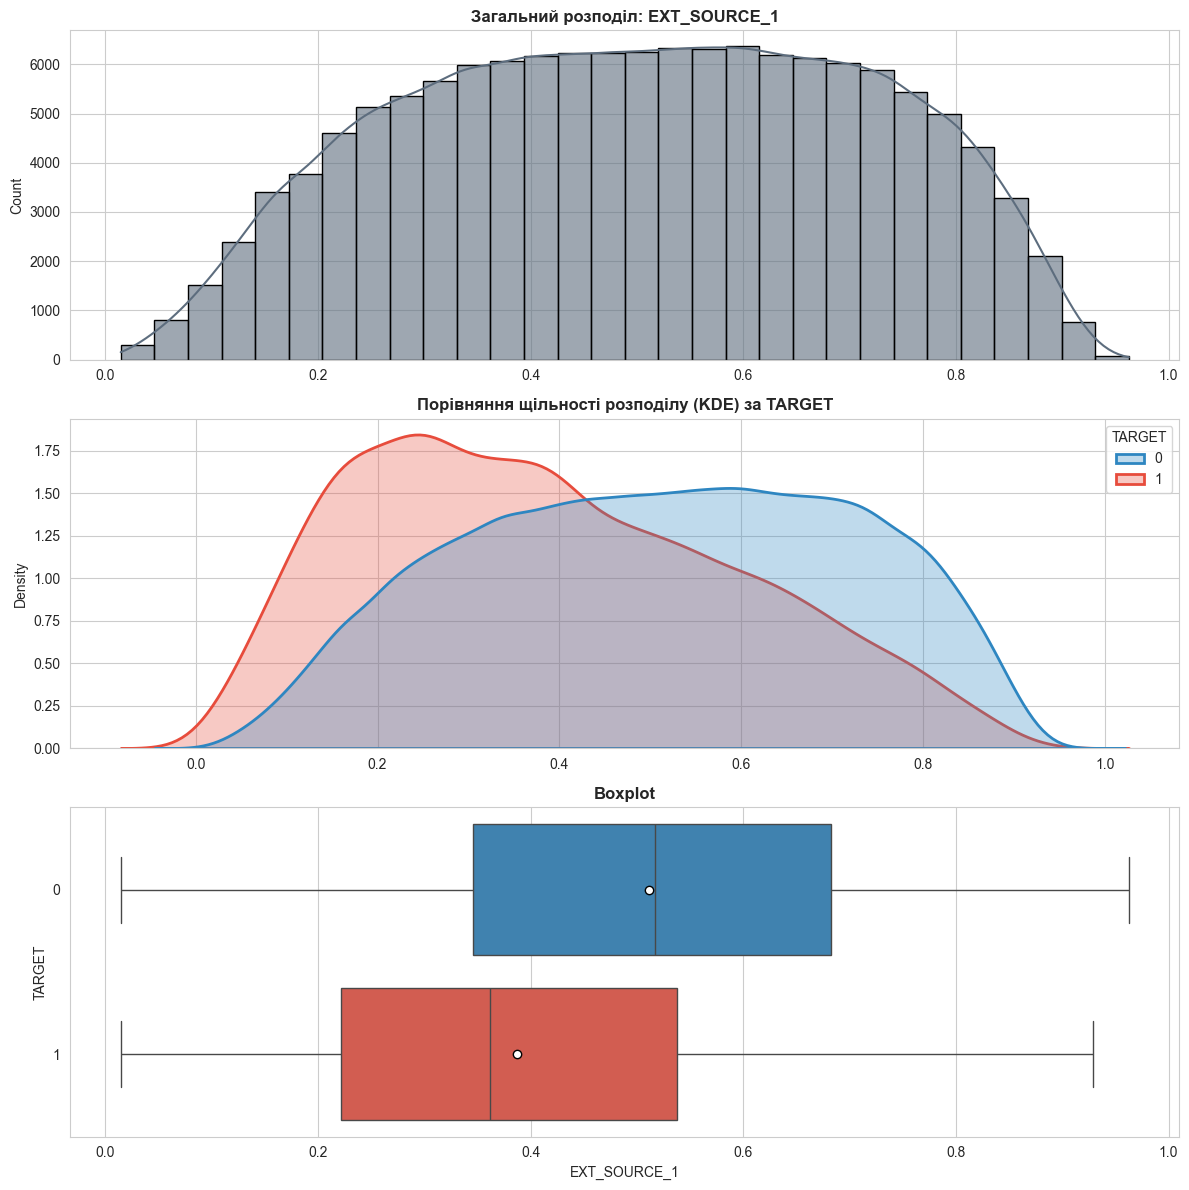

C:\Users\User\AppData\Local\Temp\ipykernel_27640\2552968679.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


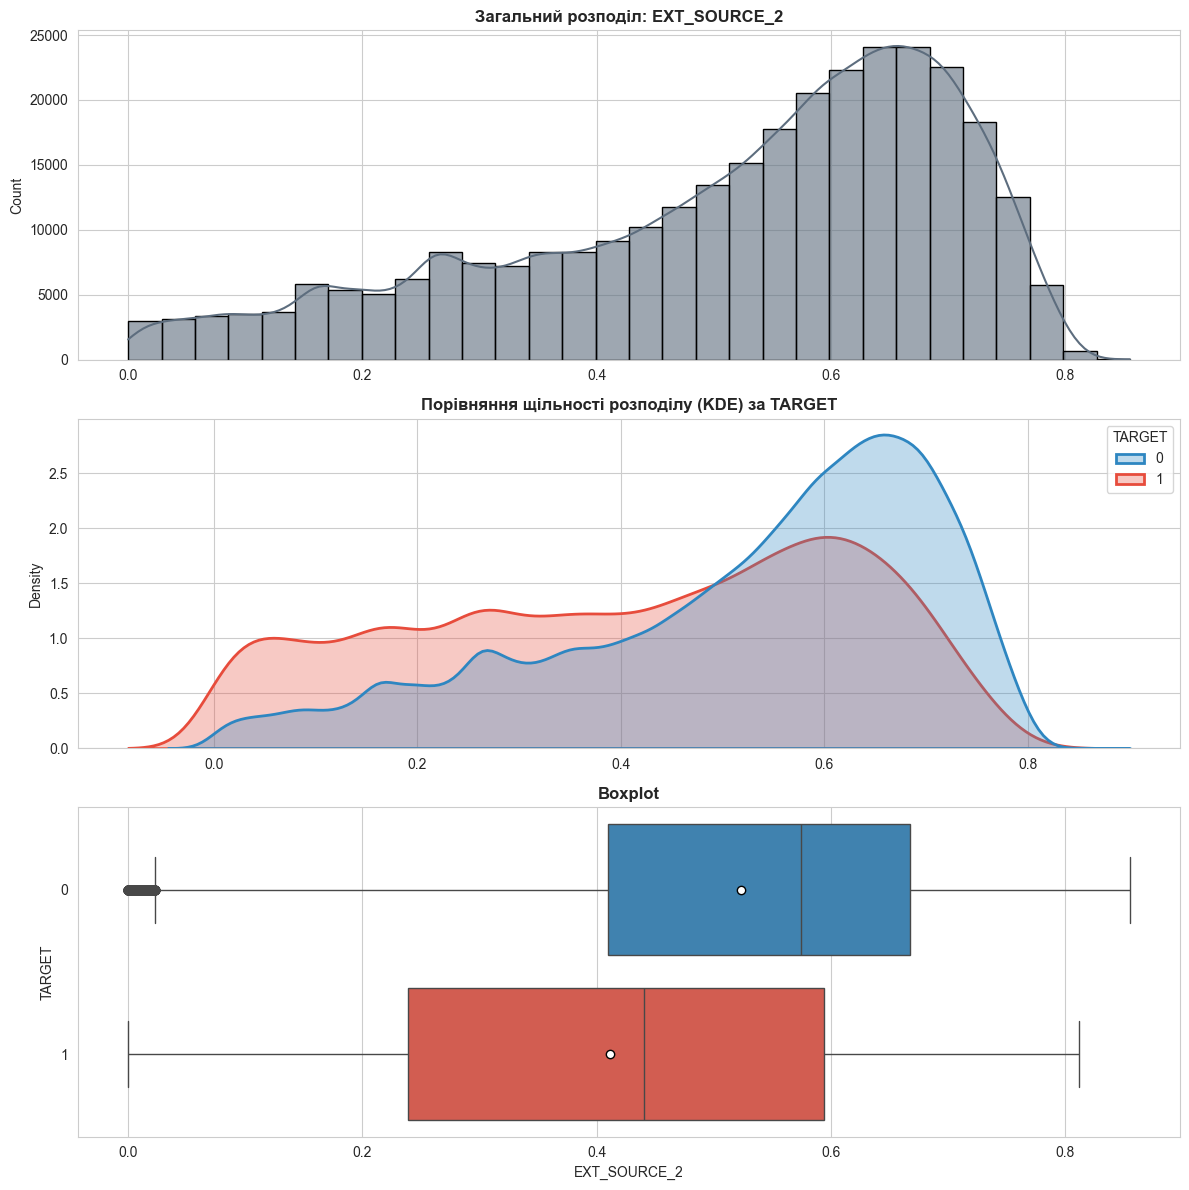

C:\Users\User\AppData\Local\Temp\ipykernel_27640\2552968679.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


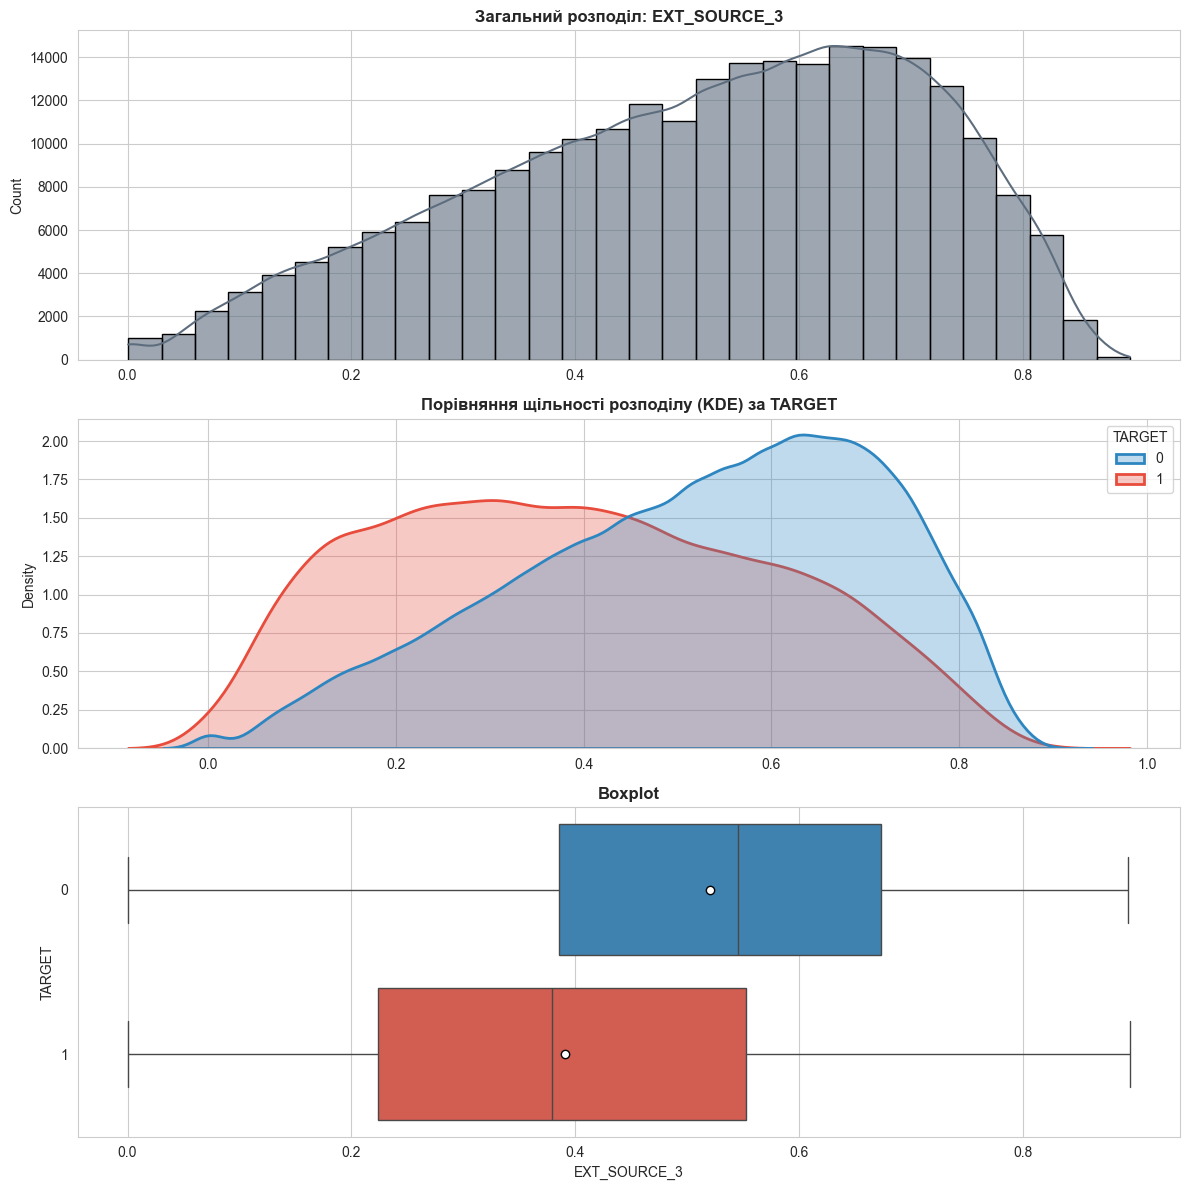

In [18]:
getNumStats('EXT_SOURCE_1')
getNumStats('EXT_SOURCE_2')
getNumStats('EXT_SOURCE_3')

Ознаки доходів мають критично високу роздільну здатність. Це зовнішні скорингові бали, які вже є агрегацією фінансової історії клієнта.

* На всіх трьох графіках KDE та Boxplot спостерігається ідентична картина: чим вищий бал, тим нижчий ризик.

* Піки розподілу для боржників зміщені ліворуч, у зону низьких значень. Піки для надійних клієнтів зміщені праворуч, у зону високих значень.

* Піки графіків KDE сильно розходяться. Це означає, що модель зможе дуже впевнено розрізняти класи на основі цих даних.

* Боксплоти показують величезний розрив між медіанами класів. Наприклад, для EXT_SOURCE_3 медіана боржників - близько 0.38, тоді як у порядочних платників - 0.55. Це колосальна різниця для однієї змінної.

* Дані вже нормалізовані, що зручно для лінійних моделей та нейромереж.

### **8. DAYS_ID_PUBLISH**

In [19]:
df_train['DAYS_ID_PUBLISH'] = -(df_train['DAYS_ID_PUBLISH'] / 365)

C:\Users\User\AppData\Local\Temp\ipykernel_27640\2552968679.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


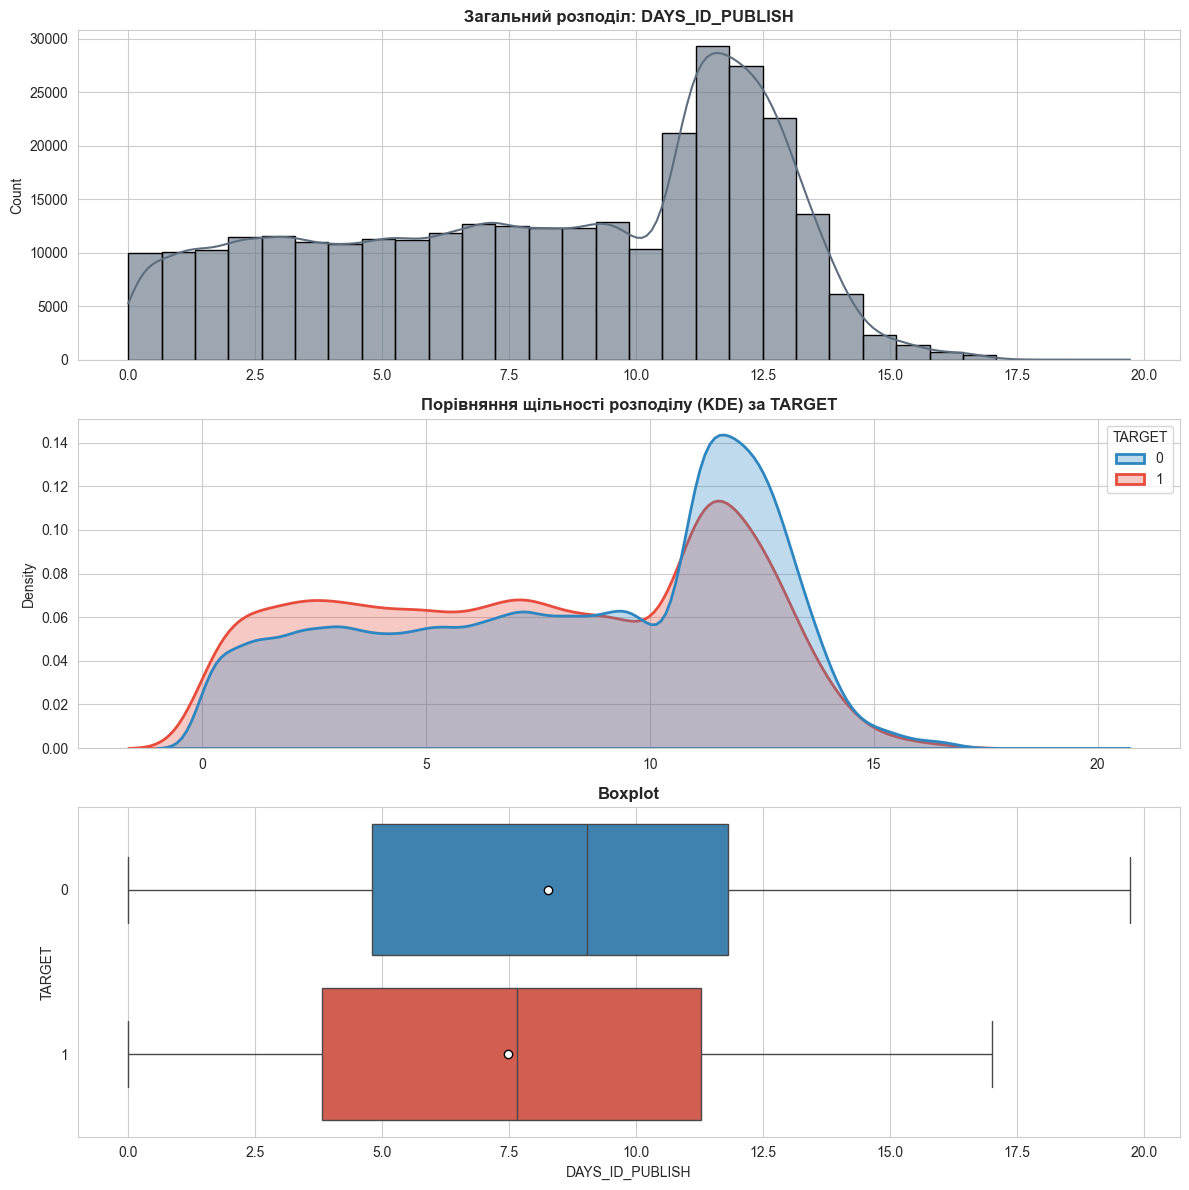

In [20]:
getNumStats('DAYS_ID_PUBLISH')

* Спостерігається чітка тенденція: клієнти, які змінили паспорт нещодавно (0–5 років тому), є більш ризиковими. На графіку KDE червона лінія помітно домінує над синьою у лівій частині графіку.

* Надійні позичальники в середньому користуються своїм документом довше. Медіана на синьому боксплоті (близько 9 років) зміщена вправо порівняно з червоним (близько 7.5 років). Це може корелювати з віком (старші люди рідше змінюють документи) або стабільністю способу життя.

### **9. DAYS_LAST_PHONE_CHANGE**

In [21]:
df_train['DAYS_LAST_PHONE_CHANGE'] = -(df_train['DAYS_LAST_PHONE_CHANGE'] / 365)

C:\Users\User\AppData\Local\Temp\ipykernel_27640\2552968679.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


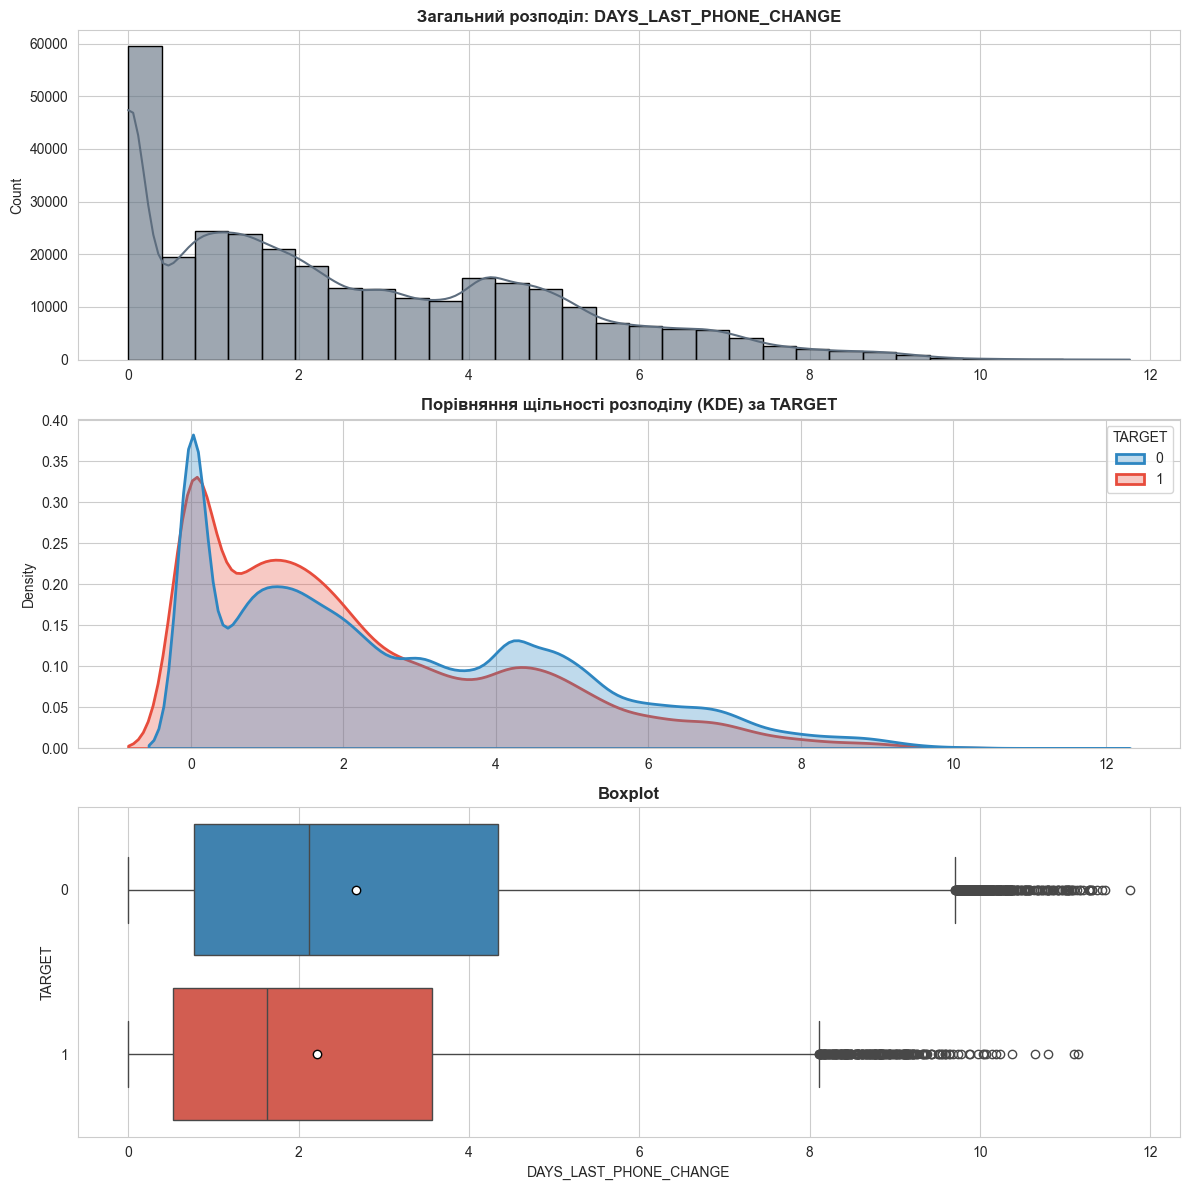

In [22]:
getNumStats('DAYS_LAST_PHONE_CHANGE')

* Клієнти, які не змінювали номер телефону протягом тривалого часу (4–8 років), є більш надійними. Медіана на синьому боксплоті помітно зміщена вправо порівняно з боржниками.

* Гістограма показує величезний сплеск значень біля 0. Це означає, що значна частина клієнтів змінює номер саме в останній рік.

* Є довгий хвіст клієнтів, які не змінювали номер 10+ років. Серед них концентрація дефолтів менша.

### **10. DAYS_REGISTRATION**

In [23]:
df_train['DAYS_REGISTRATION'] = -(df_train['DAYS_REGISTRATION'] / 365)

C:\Users\User\AppData\Local\Temp\ipykernel_27640\2552968679.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


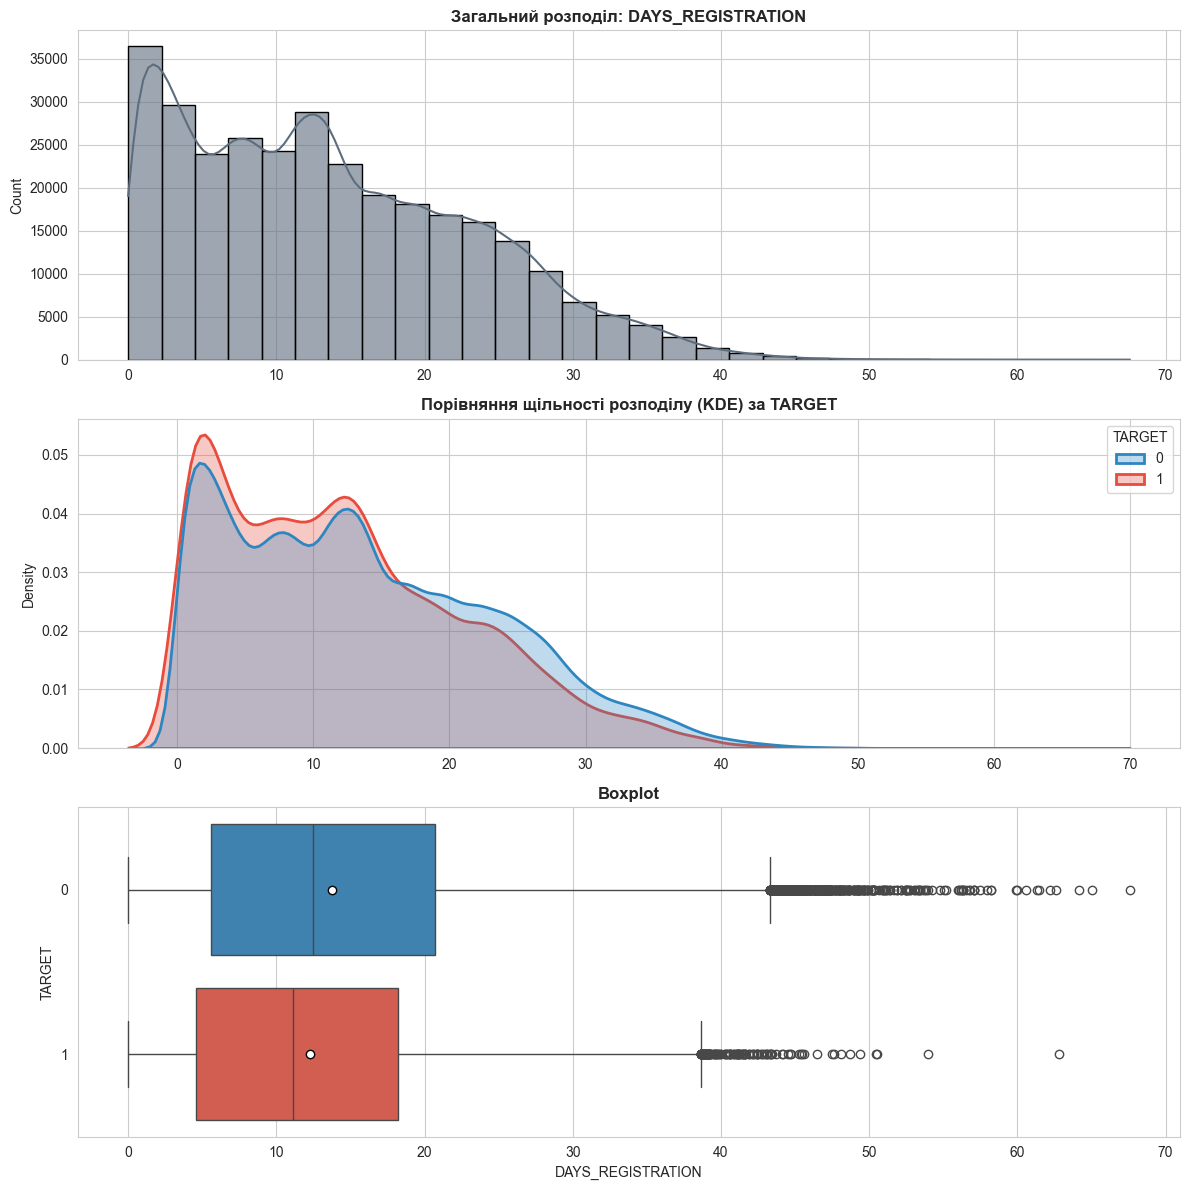

In [24]:
getNumStats('DAYS_REGISTRATION')

* Найвищий ризик спостерігається у тих, хто змінив реєстрацію нещодавно (діапазон 0–5 років). На графіку KDE червона лінія (дефолти) тут суттєво вища за синю. Це може вказувати на оренду житла, часті переїзди або нестабільний спосіб життя.

* Довгий хвіст розподілу праворуч (люди, що не змінювали прописку 30-50 років) - це, швидше за все, пенсіонери або люди старшого віку. Оскільки ми знаємо, що вік обернено корелює з ризиком, ця ознака підсилює сигнал про надійність старшої вікової групи.

* Велика кількість точок-викидів на боксплоті - це нормальні дані, їх не потрібно чистити.

## **D. Редагування датасету**

Почнемо із видалення колонок, в яких дуже багато пропущених значень. Із пункта А ми визначили такі колонки. Тепер поставимо поріг у 50% та видалимо всі ознаки, що мають більше 50% пропущених значень

In [25]:
threshold = 50
cols_to_drop = missing_data[missing_data['Percent'] > threshold].index

cols_to_drop = cols_to_drop.drop('EXT_SOURCE_1', errors='ignore')

print(f"Буде видалено {len(cols_to_drop)} колонок.")
print(f"Список на видалення: {list(cols_to_drop)}")

df_train = df_train.drop(columns=cols_to_drop)
df_test = df_test.drop(columns=cols_to_drop)

print(f'Фінальний розмір: тестовий - {df_test.shape}; тренувальний - {df_train.shape}')
df_train.head(5)

Буде видалено 40 колонок.
Список на видалення: ['COMMONAREA_AVG', 'COMMONAREA_MODE', 'COMMONAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_AVG', 'FONDKAPREMONT_MODE', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE', 'FLOORSMIN_MODE', 'FLOORSMIN_AVG', 'FLOORSMIN_MEDI', 'YEARS_BUILD_AVG', 'YEARS_BUILD_MODE', 'YEARS_BUILD_MEDI', 'OWN_CAR_AGE', 'LANDAREA_MEDI', 'LANDAREA_AVG', 'LANDAREA_MODE', 'BASEMENTAREA_MODE', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_AVG', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'ELEVATORS_AVG', 'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'WALLSMATERIAL_MODE', 'APARTMENTS_AVG', 'APARTMENTS_MEDI', 'APARTMENTS_MODE', 'ENTRANCES_MODE', 'ENTRANCES_MEDI', 'ENTRANCES_AVG', 'LIVINGAREA_AVG', 'LIVINGAREA_MEDI', 'LIVINGAREA_MODE', 'HOUSETYPE_MODE']
Фінальний розмір: тестовий - (48744, 81); тренувальний - (307511, 82)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,25.920548,-637,9.994521,5.808219,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.9722,0.0833,0.9722,0.0833,0.9722,0.0833,0.0149,No,2.0,2.0,2.0,2.0,3.106849,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,45.931507,-1188,3.249315,0.797260,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,1.0,0.0,1.0,0.0,2.268493,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,52.180822,-225,11.671233,6.934247,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,2.232877,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,52.068493,-3039,26.939726,6.676712,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,1.690411,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,54.608219,-3038,11.810959,9.473973,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3.030137,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Наступним кроком видалимо колонки, що не дають нам багато нової інформації, тобто ті, що мають високу кореляцію з іншими ознаками. Це запобігає мультиколінеарності та перенавчанню. Такі колонки ми визначили на етапі B.

In [26]:
doNotTouch = ['AMT_GOODS_PRICE', 'FLAG_EMP_PHONE', 'REGION_RATING_CLIENT_W_CITY']
toDrop = [col for col in toDrop if col not in doNotTouch]

print(f"Видаляємо {len(toDrop)} мультиколінеарних колонок.")
print(f"Приклади: {toDrop}")

df_train = df_train.drop(columns=toDrop, errors='ignore')
df_test = df_test.drop(columns=toDrop, errors='ignore')

print(f'Фінальний розмір df_train: {df_train.shape}')
print(f'Фінальний розмір df_test:  {df_test.shape}')

df_train = df_train[df_train['CODE_GENDER'] != 'XNA']

df_train.head(5)

Видаляємо 29 мультиколінеарних колонок.
Приклади: ['APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'OBS_60_CNT_SOCIAL_CIRCLE']
Фінальний розмір df_train: (307511, 77)
Фінальний розмір df_test:  (48744, 76)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,25.920548,-637,9.994521,5.808219,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.9722,0.0833,0.0149,No,2.0,2.0,2.0,3.106849,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,45.931507,-1188,3.249315,0.797260,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.9851,0.2917,0.0714,No,1.0,0.0,0.0,2.268493,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,52.180822,-225,11.671233,6.934247,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2.232877,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,52.068493,-3039,26.939726,6.676712,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,1.690411,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,54.608219,-3038,11.810959,9.473973,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,3.030137,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Якщо дивитися на колонку DAYS_EMPLOYED, то можна побачити аномалію: деякі рядки кажуть, що клієнт має 1000 років досвіду, що неможливо. Скоріш за все це особливість даних, заглушка для безробітних. Давайте виправимо цю аномалію, і заодно введемо нову колонку, що відповідатиме за наявність цієї аномалії в наборі даних:

In [27]:
anom = df_train[df_train['DAYS_EMPLOYED'] == 365243]
print(f"Кількість аномалій у DAYS_EMPLOYED: {len(anom)}")

df_train['DAYS_EMPLOYED_ANOM'] = (df_train['DAYS_EMPLOYED'] == 365243).astype(int)

df_train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

df_test['DAYS_EMPLOYED_ANOM'] = (df_test['DAYS_EMPLOYED'] == 365243).astype(int)
df_test['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

print(df_train.shape, df_test.shape)
df_train.head(5)

Кількість аномалій у DAYS_EMPLOYED: 55374
(307507, 78) (48744, 77)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,25.920548,-637.0,9.994521,5.808219,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.9722,0.0833,0.0149,No,2.0,2.0,2.0,3.106849,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,45.931507,-1188.0,3.249315,0.797260,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.9851,0.2917,0.0714,No,1.0,0.0,0.0,2.268493,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,52.180822,-225.0,11.671233,6.934247,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2.232877,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,52.068493,-3039.0,26.939726,6.676712,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,1.690411,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,54.608219,-3038.0,11.810959,9.473973,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,3.030137,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0


Наступним кроком EDA є інтерпретація категоріальних змінних. Деякі моделі не вміють працювати з категоріями, а отже треба перетворити всі категорії на числа. Робити ми це будемо наступним чином: у стовпцях, де категорії дві - зробимо LabelEncoding через 0 та 1, а де більше категорій - робимо OHE. Даний крок має значно збільшити розмірність нашого набору.

In [28]:
enc = LabelEncoder()
enc_count = 0

for col in df_train:
    if df_train[col].dtype == 'object':
        if len(list(df_train[col].unique())) <= 2:
            enc.fit(df_train[col])
            df_train[col] = enc.transform(df_train[col])
            df_test[col] = enc.transform(df_test[col])
            enc_count += 1

print(f'{enc_count} колонок закодовано через Label Encoding.')

df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

target_labels = df_train['TARGET']
df_train, df_test = df_train.align(df_test, join='inner', axis=1)
df_train['TARGET'] = target_labels

print(f'Розмір після OHE: Train {df_train.shape}, Test {df_test.shape}')
df_train.head(5)

4 колонок закодовано через Label Encoding.
Розмір після OHE: Train (307507, 184), Test (48744, 183)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,...,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,100002,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,-637.0,9.994521,5.808219,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.9722,0.0833,0.0149,2.0,2.0,2.0,3.106849,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,1
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,45.931507,-1188.0,3.249315,0.797260,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.9851,0.2917,0.0714,1.0,0.0,0.0,2.268493,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

Наступним важливим кроком є заповнення пропусків. Як ми виявили в пункті А, у нас багато місінг дати в наборі. Ці значення можна заповнювати багатьма способами - від просто нулів до тренування окремої моделі для заповнення пропущених значень. Ми ж маємо фінансові дані. У фінансових даних часто є викиди (наприклад, багачі). Середнє значення буде перекошене, а от медіана є стійкою до викидів. Тому краще заповнювати медіаною.

In [29]:
feature_cols = df_train.columns.drop('TARGET')

imputer = SimpleImputer(strategy='median')

imputer.fit(df_train[feature_cols])

df_train[feature_cols] = imputer.transform(df_train[feature_cols])
df_test[feature_cols] = imputer.transform(df_test[feature_cols])

print(f"Залишилось пропусків у df_train: {df_train[feature_cols].isnull().sum().sum()}")

Залишилось пропусків у df_train: 0


Наступним критичним етапом є приведення даних до єдиного масштабу. Моделі машинного навчання погано працюють, коли одна ознака вимірюється в мільйонах (дохід), а інша — в одиницях (кількість дітей), адже великі числа можуть помилково вважатися більш вагомими.

Тут існує два підходи: нормалізація та стандартизація. Для фінансових даних нормалізація (стиснення в діапазон 0–1) є небезпечною через наявність значних викидів. Якщо у вибірці є хоча б один клієнт із надвисоким доходом, він стане одиницею, а всі "звичайні" клієнти будуть сплюснуті в мікроскопічні значення близько нуля. Через це модель втратить здатність розрізняти їх між собою.

Саме тому було обрано стандартизацію. Вона центрує дані навколо нуля і не заганяє їх у жорсткі рамки. Це дозволяє зберегти структуру розподілу та інформативність даних, навіть за наявності аномально великих сум кредитів чи доходів.

In [30]:
scale_cols = df_train.select_dtypes(include=['number']).columns.drop(['TARGET', 'SK_ID_CURR'])

scaler = StandardScaler()
scaler.fit(df_train[scale_cols])

df_train[scale_cols] = scaler.transform(df_train[scale_cols])
df_test[scale_cols] = scaler.transform(df_test[scale_cols])

df_train.head(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,...,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,100002.0,-0.324373,1.388162,-0.717910,0.664538,-0.577534,0.142129,-0.478099,-0.166149,-0.507239,-0.149444,-1.506889,0.755835,-0.379840,-0.579152,0.001803,0.468701,-0.498997,0.043245,1.599374,-0.245217,-1.265716,-0.103059,-0.062693,-0.631813,-0.124005,-0.231268,-0.20587,-0.29121,-0.547240,-0.467818,-3.021864,-1.317935,-2.153683,-0.174888,-1.061571,-0.902011,0.242883,4.164042,5.254315,0.206989,-0.006502,0.639051,-0.009017,-0.123883,-0.31074,-0.013853,-0.297634,-0.062539,-0.004771,-0.06267,-0.00255,-0.059478,-0.054269,-0.034802,-0.100139,-0.016332,-0.090535,-0.024402,-0.022529,-0.018305,...,-0.037377,-0.089691,-0.090662,-0.140864,-0.188514,1.876884,-0.02909,-0.149482,-0.035129,-0.055668,-0.042713,-0.187131,-0.056136,-0.098553,-0.058226,-0.018831,-0.094188,-0.034661,-0.014762,-0.038621,-0.103786,-0.05348,-0.044178,-0.019088,-0.065333,-0.008835,-0.105233,-0.044104,-0.151268,-0.031509,-0.194347,-0.09295,-0.032124,-0.239509,-0.087586,-0.084048,-0.035909,-0.016628,-0.076969,-0.172571,-0.103304,-0.080379,-0.377816,-0.071751,-0.043358,-0.03366,-0.07884

## **E. Тренування моделі**

Ми успішно завершили етап підготовки даних. Наші дані пройшли повний цикл підготовки: ми заповнили пропуски медіанами, видалили непотрібні колонки, закодували категорії в цифри та стандартизували числові ознаки, привівши їх до єдиного масштабу. Тепер датасет повністю готовий до навчання.

Розділимо наш тренувальний набір на дві частини у пропорції 80/20.

У якості першої моделі обрано логістичну регресію. Метрика - ROC-AUC

In [31]:
cols_to_drop = ['TARGET', 'SK_ID_CURR']
X = df_train.drop(columns=cols_to_drop, errors='ignore')
y = df_train['TARGET']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Розміри: Train={X_train.shape}, Validation={X_val.shape}")
print("-" * 30)

print("Running Logistic Regression...")
lr = LogisticRegression(C=0.1, solver='liblinear', random_state=42)
lr.fit(X_train, y_train)

lr_pred = lr.predict_proba(X_val)[:, 1]
lr_score = roc_auc_score(y_val, lr_pred)
print(f"Logistic Regression ROC-AUC: {lr_score:.5f}")

Розміри: Train=(246005, 182), Validation=(61502, 182)
------------------------------
Running Logistic Regression...
Logistic Regression ROC-AUC: 0.74864


Ми отримали майже 0.75 на найпростішій лінійній моделі — це ознака того, що етап очищення даних був проведений якісно. Дані мають високу роздільну здатність.

Логістична регресія бачить лише лінійні залежності. Вона не розуміє складних зв'язків. А отже тепер ми можемо запустити більш потужний алгоритм машинного навчання - градієнтний бустінг, який здатний знаходити нелінійні патерни.

In [32]:
xgb_model = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
    eval_metric='auc'
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100
)

xgb_pred = xgb_model.predict_proba(X_val)[:, 1]
xgb_score = roc_auc_score(y_val, xgb_pred)

print("-" * 30)
print(f"XGBoost ROC-AUC: {xgb_score:.5f}")
print("-" * 30)

[0]	validation_0-auc:0.68516	validation_1-auc:0.68704
[100]	validation_0-auc:0.74901	validation_1-auc:0.74635
[200]	validation_0-auc:0.75917	validation_1-auc:0.75441
[300]	validation_0-auc:0.76452	validation_1-auc:0.75737
[400]	validation_0-auc:0.76878	validation_1-auc:0.75941
[500]	validation_0-auc:0.77224	validation_1-auc:0.76062
[600]	validation_0-auc:0.77548	validation_1-auc:0.76169
[700]	validation_0-auc:0.77834	validation_1-auc:0.76252
[800]	validation_0-auc:0.78106	validation_1-auc:0.76302
[900]	validation_0-auc:0.78337	validation_1-auc:0.76330
[1000]	validation_0-auc:0.78572	validation_1-auc:0.76353
[1100]	validation_0-auc:0.78813	validation_1-auc:0.76375
[1200]	validation_0-auc:0.79027	validation_1-auc:0.76397
[1214]	validation_0-auc:0.79060	validation_1-auc:0.76395
------------------------------
XGBoost ROC-AUC: 0.76401
------------------------------


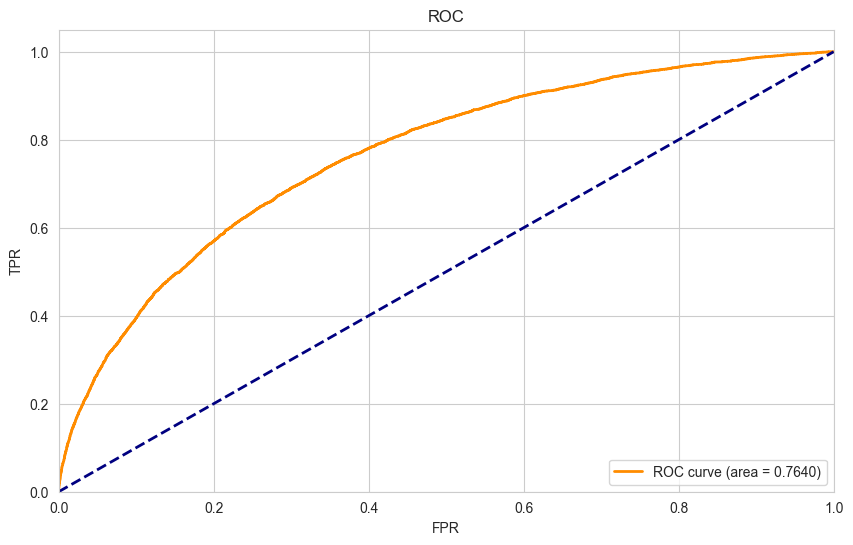

In [33]:
fpr, tpr, thresholds = roc_curve(y_val, xgb_pred)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Як бачимо, XGBoost впорався із задачею краще, ніж звичайна логістична регресія, і площа під кривою на графіку ROC-AUC значно більша, ніж площа при звичайному вгадуванні. Виведемо список найважливіших ознак:

C:\Users\User\AppData\Local\Temp\ipykernel_27640\2527773973.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Value", y="Feature", data=feature_imp, palette="viridis")


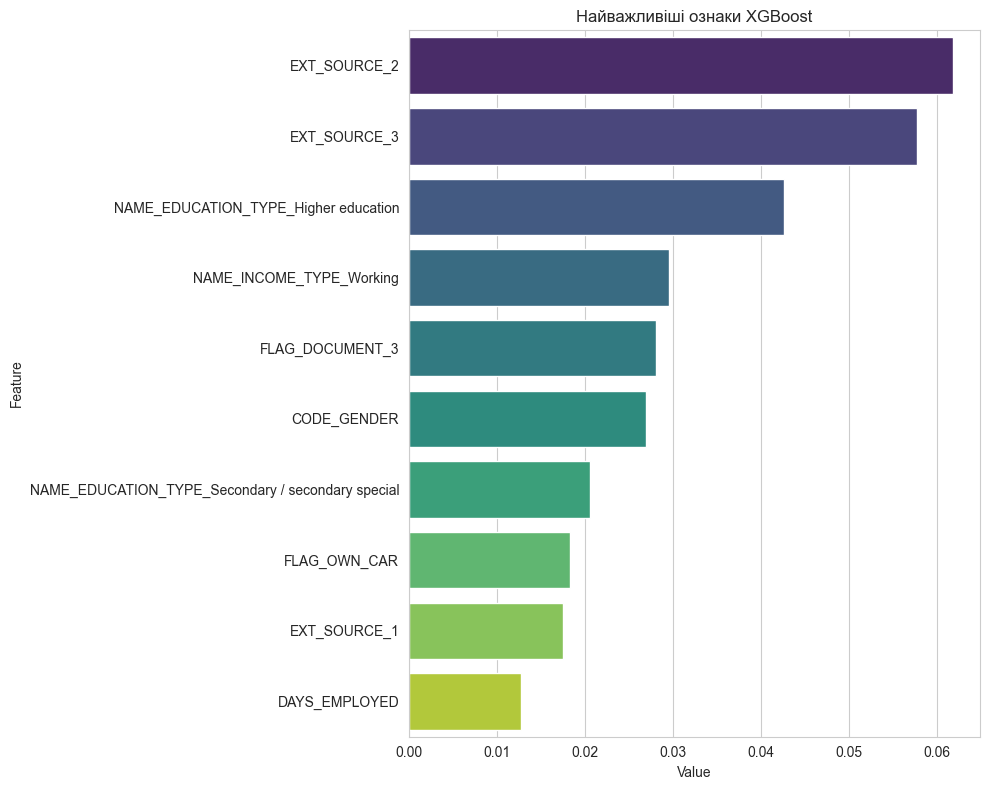

In [34]:
importances = xgb_model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(importances, X_train.columns)), columns=['Value','Feature'])
feature_imp = feature_imp.sort_values(by="Value", ascending=False).head(10)

plt.figure(figsize=(10, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp, palette="viridis")
plt.title(f'Найважливіші ознаки XGBoost')
plt.tight_layout()
plt.show()

Із діаграми важливостей ознак можна зробити такі висновки:

* Абсолютна домінація зовнішніх джерел (EXT_SOURCE_2, EXT_SOURCE_3). Це підтверджує, що кредитний скоринг від інших бюро є набагато точнішим, ніж те, що клієнт розповідає про себе сам. Модель бачить: якщо інші банки кажуть, що клієнт надійний, то так воно і є.

* NAME_EDUCATION_TYPE_Higher education - це третя за силою ознака. Наявність вищої освіти для моделі є сильним сигналом. Зазвичай люди з вищою освітою мають більш стабільний дохід і фінансову грамотність, що знижує ризик дефолту.

* CODE_GENDER - четверте місце. Виходить, що жінки статистично є більш дисциплінованими платниками, ніж чоловіки. Модель це чітко вловила.


Тепер спробуємо використати навчену модель для передбачення TARGET на тестових даних і надішлемо відповідь на Kaggle:

In [35]:
test_ids = df_test['SK_ID_CURR']

X_test_final = df_test.drop(columns=['SK_ID_CURR', 'TARGET'], errors='ignore')
predictions = xgb_model.predict_proba(X_test_final)[:, 1]

submission = pd.DataFrame({
    'SK_ID_CURR': test_ids,
    'TARGET': predictions
})

submission['SK_ID_CURR'] = submission['SK_ID_CURR'].astype(int)

submission.to_csv('data/submission_final.csv', index=False)
print(submission.head())

   SK_ID_CURR    TARGET
0      100001  0.053693
1      100005  0.207790
2      100013  0.043098
3      100028  0.098557
4      100038  0.181154


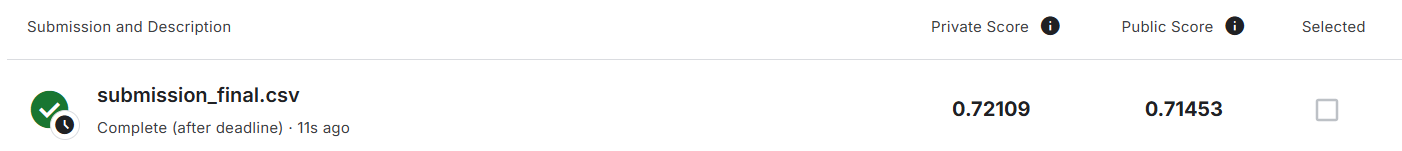

## **Висновок**

У ході виконання лабораторної роботи було проведено розвідувальний аналіз даних (EDA) на датасеті Home Credit Default Risk. Роботу було розпочато з оцінки якості даних: проаналізовано відсоток пропусків та виявлено стовпці з надмірною кількістю відсутніх значень, які було відфільтровано. Також було вирішено проблему мультиколінеарності - видалено дублюючі ознаки з кореляцією вище 0.95, що дозволило зменшити розмірність даних та пришвидшити навчання без втрати інформативності.

Особливу увагу було приділено передобробці даних. Було виявлено та опрацьовано характерну аномалію у стовпці DAYS_EMPLOYED (значення 365243, що відповідає 1000 рокам стажу) - ці дані замінено на NaN з додаванням відповідного прапорця аномалії. Пропуски в даних було заповнено медіанними значеннями, що є стійким методом для фінансових даних з викидами. Категоріальні змінні були закодовані методами Label Encoding та One-Hot Encoding, а числові ознаки - стандартизовані.

В якості базової моделі було використано логістичну регресію, яка показала результат ROC-AUC 0.748 на валідаційній вибірці. Для покращення результату було застосовано алгоритм градієнтного бустінгу XGBoost. Це дозволило врахувати нелінійні залежності та підняти скор на валідації до 0.764. Аналіз важливості ознак показав, що зовнішні джерела оцінки (EXT_SOURCE_X) та рівень освіти (EDUCATION_TYPE) мають найбільшу вагу при прийнятті рішень моделлю.

Фінальним етапом стало формування файлу передбачень та перевірка моделі на тестовій частині. Отриманий результат підтвердив працездатність моделі, але також вказав на наявність перенавчання.

Отже, було успішно пройдено повний цикл проєкту: від чистки сирих даних до генерації фінального файлу. Отриманий результат є конкурентним для базового рішення. Подальше підвищення точності можливе шляхом впровадження крос-валідації (K-Fold) для зменшення оверфіту, відмови від стандартизації для деревних моделей, а також більш детального налаштування гіперпараметрів XGBoost.